# Universidad de Buenos Aires
# TP FINAL-COMPUTER VISION 2
# Alumnos: Matias Werbin y Noelia Qualindi

## Preprocesamiento de datos y análisis exploratorio de datos

In [5]:
# importación de librerias
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dense, Flatten, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LambdaCallback, EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.resnet50 import preprocess_input,ResNet50
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.applications import InceptionV3
import numpy as np
import random
import os
from tqdm import tqdm
import pickle
import cv2
import matplotlib.pyplot as plt


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:

# Cargar datos de train y test

#!unzip '/content/drive/MyDrive/Colab Notebooks/Brain-Tumor-Classification-DataSet-master.zip'

!unzip '/content/drive/MyDrive/TP FINAL VCII/Brain-Tumor-Classification-DataSet-master.zip'



Archive:  /content/drive/MyDrive/TP FINAL VCII/Brain-Tumor-Classification-DataSet-master.zip
3ea9f4eae54c67e5bddbf6f7a73582967a5f5f79
   creating: Brain-Tumor-Classification-DataSet-master/
   creating: Brain-Tumor-Classification-DataSet-master/Testing/
   creating: Brain-Tumor-Classification-DataSet-master/Testing/glioma_tumor/
  inflating: Brain-Tumor-Classification-DataSet-master/Testing/glioma_tumor/image(1).jpg  
  inflating: Brain-Tumor-Classification-DataSet-master/Testing/glioma_tumor/image(10).jpg  
  inflating: Brain-Tumor-Classification-DataSet-master/Testing/glioma_tumor/image(100).jpg  
  inflating: Brain-Tumor-Classification-DataSet-master/Testing/glioma_tumor/image(11).jpg  
  inflating: Brain-Tumor-Classification-DataSet-master/Testing/glioma_tumor/image(12).jpg  
  inflating: Brain-Tumor-Classification-DataSet-master/Testing/glioma_tumor/image(13).jpg  
  inflating: Brain-Tumor-Classification-DataSet-master/Testing/glioma_tumor/image(14).jpg  
  inflating: Brain-Tumor-

In [3]:
# rutas
TEST_PATH = '/content/Brain-Tumor-Classification-DataSet-master/Testing'
TRAIN_PATH = '/content/Brain-Tumor-Classification-DataSet-master/Training'
# tamaño de imagen
IMG_SIZE = 224
#  categorias
CATEGORIES = ["glioma_tumor","meningioma_tumor","no_tumor","pituitary_tumor"]

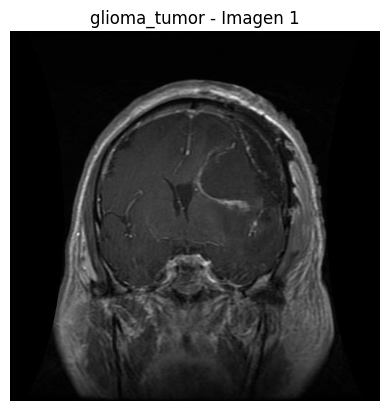

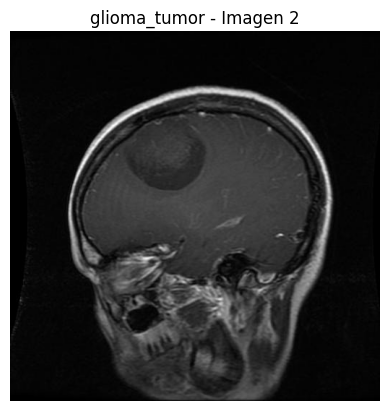

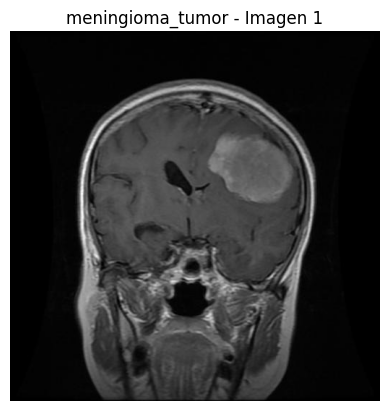

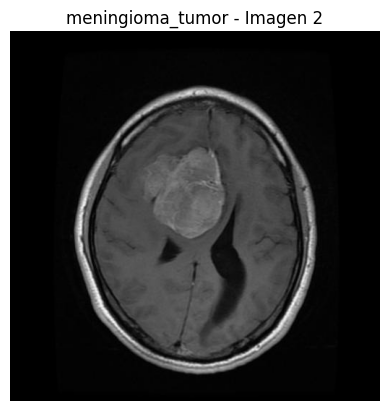

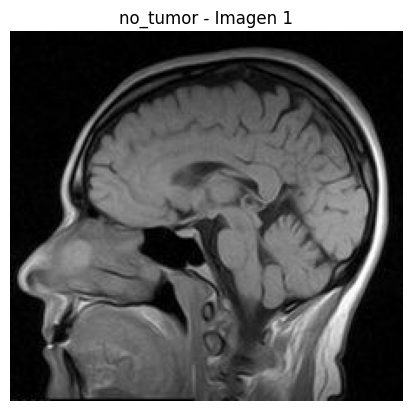

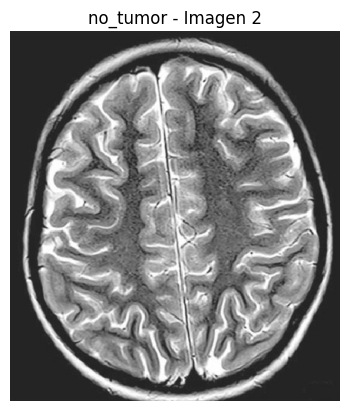

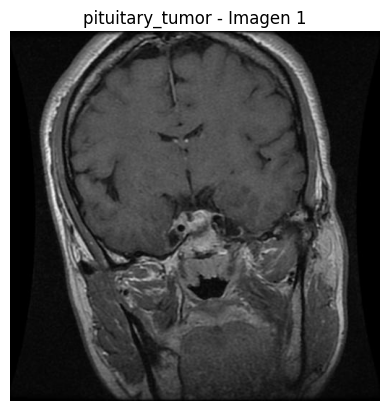

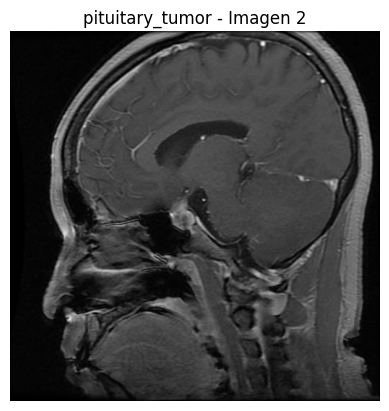

In [ ]:
for category in CATEGORIES:
  image_files=os.listdir(os.path.join(TRAIN_PATH,category))
  if len(image_files)>=2:
    for i in range(2):
      image_path=os.path.join(TRAIN_PATH,category,image_files[i])
      image=cv2.imread(image_path)

      plt.imshow(image)
      plt.title(f"{category} - Imagen {i+1}")
      plt.axis('off')
      plt.show()


In [6]:
# Preparación de data train

train_data=[]

def create_train():
  """ Funcion para generar dataset de train con array de imagenes y etiquetas"""
  for category in CATEGORIES:
    path=os.path.join(TRAIN_PATH,category)
    classes=CATEGORIES.index(category)
    for img in tqdm(os.listdir(path)):
      img_array=cv2.imread(os.path.join(path,img), cv2.IMREAD_COLOR)
      resized_array=cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
      train_data.append([resized_array,classes])

  random.shuffle(train_data)
  return train_data

train_dataset=create_train()

X_train = np.array([item[0] for item in train_dataset]).reshape(-1,IMG_SIZE,IMG_SIZE,3)
y_train = np.array([item[1] for item in train_dataset])




100%|██████████| 827/827 [00:01<00:00, 471.89it/s]


In [ ]:
# Cantidad de imagenes de entrenamiento
len(X_train)

2870

In [ ]:
# Cantidad de etiquetas de entrenamiento
len(y_train)

2870

In [ ]:
label, frecuencias = np.unique(y_train, return_counts=True)

for label, frecuencia in zip(label, frecuencias):
    print(f"Label: {label}, Frecuencia: {frecuencia}")

Label: 0, Frecuencia: 826
Label: 1, Frecuencia: 822
Label: 2, Frecuencia: 395
Label: 3, Frecuencia: 827


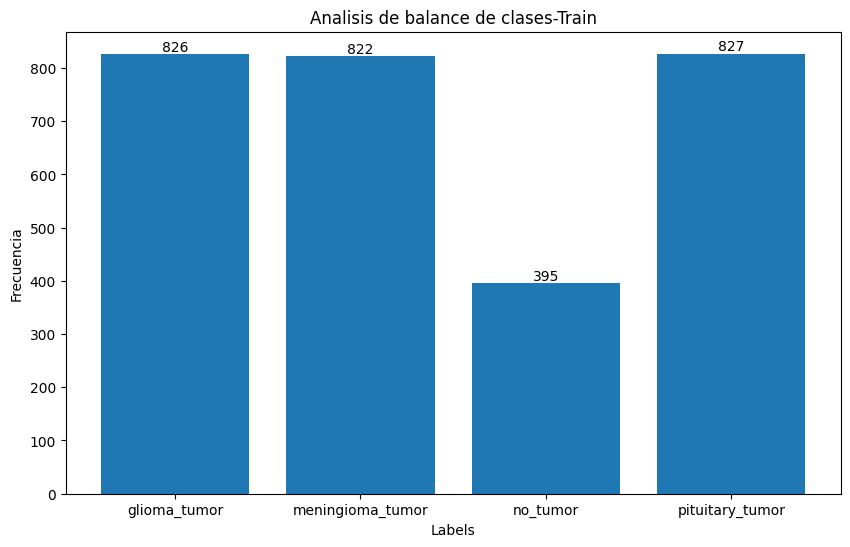

In [ ]:
plt.figure(figsize=(10,6))
plt.bar(CATEGORIES, frecuencias)

for i, freq in enumerate(frecuencias):
    plt.text(i, freq, str(freq), ha='center', va='bottom')

plt.xlabel('Labels')
plt.ylabel('Frecuencia')
plt.title("Analisis de balance de clases-Train")
plt.show()


Podemos observar que se presenta un desbalance de clase. En este caso, la clase minororitaria es no_tumor. Esto a priori no deberia presentar un problema porque nos interesa que la red pueda aprender a clasificar las imagenes que son tumores de las que no. De igual manera, tambien es muy importante poder predecir correctamente las que no son pero en este tipo de problemas es mas critico el TP de las clases asociadas a tumores.

In [ ]:
idx2category = {i: category for i, category in enumerate(CATEGORIES)}
idx2category

{0: 'glioma_tumor', 1: 'meningioma_tumor', 2: 'no_tumor', 3: 'pituitary_tumor'}

In [ ]:
category2idx = {category: i for i, category in enumerate(CATEGORIES)}
category2idx

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}

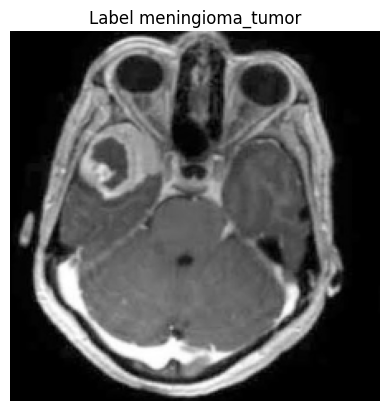

In [ ]:
# Visualizar la primera imagen
plt.imshow(X_train[0], cmap='gray')
plt.title(f"Label {idx2category.get(y_train[0],-1)}")
plt.axis('off')
plt.show()

In [7]:
test_data=[]

def create_test():
  """ Funcion para generar dataset de test con array de imagenes y etiquetas"""
  for category in CATEGORIES:
    path=os.path.join(TEST_PATH,category)
    classes=CATEGORIES.index(category)
    for img in tqdm(os.listdir(path)):
      img_array=cv2.imread(os.path.join(path,img), cv2.IMREAD_COLOR)
      resized_array=cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
      test_data.append([resized_array,classes])

  random.shuffle(test_data)
  return test_data

test_dataset=create_test()

X_test = np.array([item[0] for item in test_dataset]).reshape(-1,IMG_SIZE,IMG_SIZE,3)
y_test = np.array([item[1] for item in test_dataset])


100%|██████████| 74/74 [00:00<00:00, 266.92it/s]


In [ ]:
# Cantidad de imagenes de testeo
len(X_test)

394

In [ ]:
# Cantidad de etiquetas de testeo
len(y_test)

394

Label: 0, Frecuencia: 100
Label: 1, Frecuencia: 115
Label: 2, Frecuencia: 105
Label: 3, Frecuencia: 74



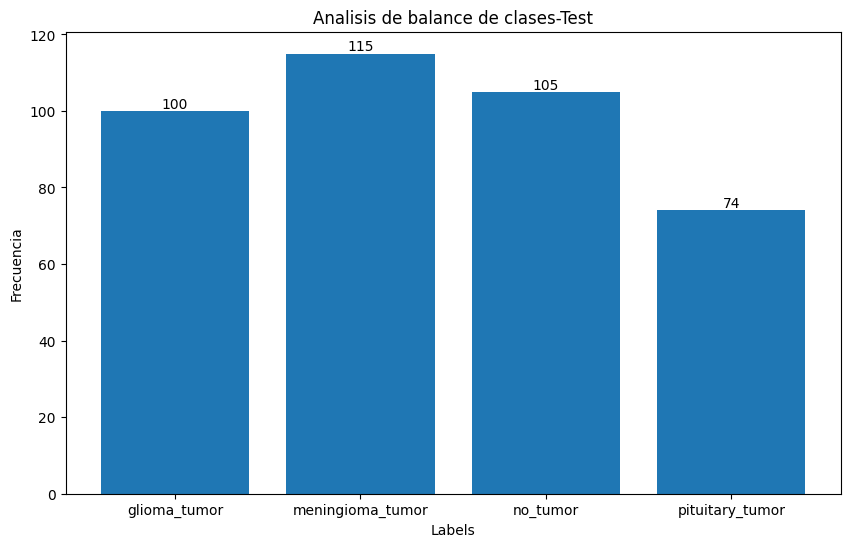

In [ ]:
label, frecuencias = np.unique(y_test, return_counts=True)

for label, frecuencia in zip(label, frecuencias):
    print(f"Label: {label}, Frecuencia: {frecuencia}")

print("")

plt.figure(figsize=(10,6))

plt.bar(CATEGORIES,frecuencias)

for i, freq in enumerate(frecuencias):
    plt.text(i, freq, str(freq), ha='center', va='bottom')

plt.xlabel("Labels")
plt.ylabel("Frecuencia")
plt.title("Analisis de balance de clases-Test")
plt.show()




Podemos observar que el set de testeo se encuentra bastante balanceado por lo que podemos usar el accuracy como metrica de validación.

In [ ]:
# Normalización de X_train y X_test

from tensorflow.keras.applications.vgg16 import preprocess_input

X_train_vgg16 = preprocess_input(X_train)
X_test_vgg16 = preprocess_input(X_test)

# Armamos sets de validación

from sklearn.model_selection import train_test_split

X_train_vgg16, X_valid_vgg16, y_train_vgg16, y_valid_vgg16=train_test_split(X_train_vgg16,y_train, test_size=0.25, random_state=74,stratify=y_train)


In [ ]:
print(f"Shape X_train{X_train_vgg16.shape}")
print(f"Shape X_valid{X_valid_vgg16.shape}")
print(f"Shape X_test{X_test_vgg16.shape}")
print(f"Shape y_train{y_train_vgg16.shape}")
print(f"Shape y_valid{y_valid_vgg16.shape}")
print(f"Shape y_test{y_test.shape}")

Shape X_train(2152, 224, 224, 3)
Shape X_valid(718, 224, 224, 3)
Shape X_test(394, 224, 224, 3)
Shape y_train(2152,)
Shape y_valid(718,)
Shape y_test(394,)


In [8]:
# Callbacks

from tensorflow.keras.callbacks import LambdaCallback, EarlyStopping, ModelCheckpoint

def create_callbacks(model_name):
    # Callback para imprimir la pérdida y la métrica en cada época
    print_epoch_callback = LambdaCallback(
        on_epoch_end=lambda epoch, logs: print(
            f"Epoch {epoch + 1}: Loss: {logs['loss']:.4f}, Accuracy: {logs.get('accuracy', 'N/A'):.4f}, "
            f"Val Loss: {logs['val_loss']:.4f}, Val Accuracy: {logs.get('val_accuracy', 'N/A'):.4f}"
        )
    )

    # Callback de EarlyStopping para monitorear la métrica de validación
    es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5)

    #  Callback de ModelCheckpoint para guardar el mejor modelo
    mc = ModelCheckpoint(f'/content/drive/MyDrive/TP FINAL VCII/{model_name}_best_model.keras', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

    return [print_epoch_callback, es, mc]



##VGG16

In [ ]:
# Carga de VGG16 sin cabezal de clasificación

vgg16_model=VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
vgg16_model.summary()


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Haremos transfer learning (feature extration) eliminando la capa densa de clasificación y adaptandola a nuestro problema.

In [ ]:
# Cargamos layers a modelo
model = Sequential()
for layer in vgg16_model.layers:
    model.add(layer)

# Congelamos las capas de VGG16
for layer in model.layers:
    layer.trainable = False
# Incorporamos cabeza de clasificación de 4 clases
model.add(Flatten())
model.add(Dense(4, activation='softmax'))

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model_name='vgg16_tl_noaug_es'

callbacks=create_callbacks(model_name)

In [ ]:
history_vgg16_noaug = model.fit(
    X_train_vgg16, y_train_vgg16,
    validation_data=[X_valid_vgg16, y_valid_vgg16],
    batch_size=32,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
68/68 [==============================] - ETA: 0s - loss: 5.0112 - accuracy: 0.7807Epoch 1: Loss: 5.0112, Accuracy: 0.7807, Val Loss: 2.5248, Val Accuracy: 0.8719

Epoch 1: val_accuracy improved from -inf to 0.87187, saving model to /content/drive/MyDrive/TP FINAL VCII/vgg16_tl_noaug_es_best_model.h5
68/68 [==============================] - 30s 324ms/step - loss: 5.0112 - accuracy: 0.7807 - val_loss: 2.5248 - val_accuracy: 0.8719


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/50
67/68 [============================>.] - ETA: 0s - loss: 0.8724 - accuracy: 0.9314Epoch 2: Loss: 0.8691, Accuracy: 0.9317, Val Loss: 3.7269, Val Accuracy: 0.8621

Epoch 2: val_accuracy did not improve from 0.87187
68/68 [==============================] - 11s 159ms/step - loss: 0.8691 - accuracy: 0.9317 - val_loss: 3.7269 - val_accuracy: 0.8621
Epoch 3/50
68/68 [==============================] - ETA: 0s - loss: 0.5250 - accuracy: 0.9596Epoch 3: Loss: 0.5250, Accuracy: 0.9596, Val Loss: 2.6494, Val Accuracy: 0.9039

Epoch 3: val_accuracy improved from 0.87187 to 0.90390, saving model to /content/drive/MyDrive/TP FINAL VCII/vgg16_tl_noaug_es_best_model.h5
68/68 [==============================] - 12s 172ms/step - loss: 0.5250 - accuracy: 0.9596 - val_loss: 2.6494 - val_accuracy: 0.9039
Epoch 4/50
67/68 [============================>.] - ETA: 0s - loss: 0.2846 - accuracy: 0.9748Epoch 4: Loss: 0.2836, Accuracy: 0.9749, Val Loss: 2.6397, Val Accuracy: 0.8997

Epoch 4: val_accuracy 

In [ ]:
history_save_path = '/content/drive/MyDrive/TP FINAL VCII/history_vgg16_tl_noaug_es.pkl'
weights_save_path="/content/drive/MyDrive/TP FINAL VCII/weights_vgg16_tl_noaug_es.h5"


# Guarda history
with open(history_save_path, 'wb') as f:
    pickle.dump(history_vgg16_noaug.history, f)
print(f"History guardado en {history_save_path}")

# Guardar weights
model.save_weights(weights_save_path)
print(f"Pesos guardado en {weights_save_path}")

History guardado en /content/drive/MyDrive/TP FINAL VCII/history_vgg16_tl_noaug_es.pkl
Pesos guardado en /content/drive/MyDrive/TP FINAL VCII/weights_vgg16_tl_noaug_es.h5


In [ ]:
train_loss=history_vgg16_noaug.history['loss']
train_acc=history_vgg16_noaug.history['accuracy']
val_loss=history_vgg16_noaug.history['val_loss']
val_acc=history_vgg16_noaug.history['val_accuracy']


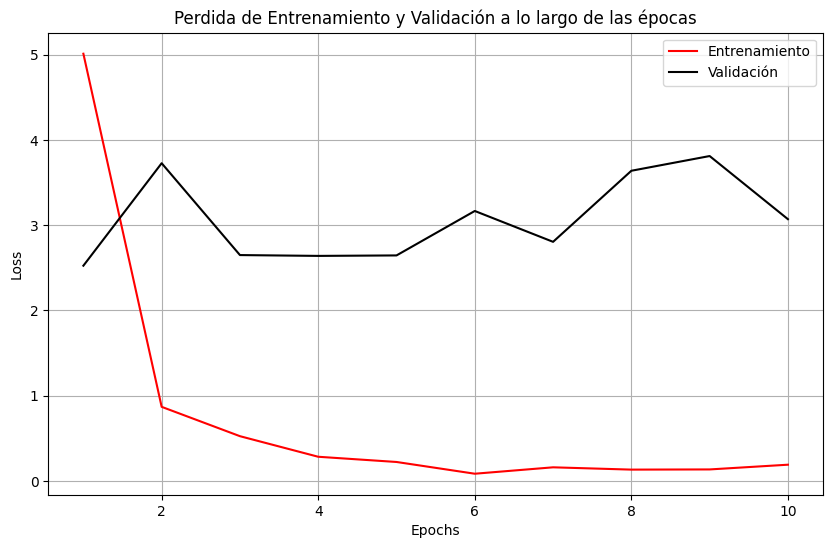

In [ ]:
plt.figure(figsize=(10,6))

plt.plot(range(1, len(train_loss)+1),train_loss, color='r')
plt.plot(range(1, len(train_loss)+1),val_loss, color='black')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Perdida de Entrenamiento y Validación a lo largo de las épocas')
plt.grid(True)
plt.legend(['Entrenamiento', 'Validación'])
plt.show()

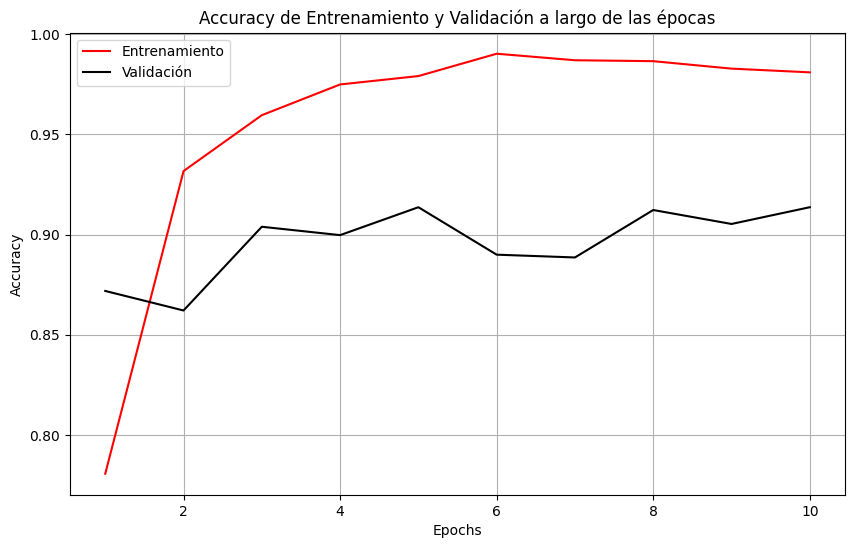

In [ ]:
plt.figure(figsize=(10,6))

plt.plot(range(1,len(train_acc) + 1 ),train_acc, color='r')
plt.plot(range(1,len(train_acc) + 1),val_acc, color='black')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy de Entrenamiento y Validación a largo de las épocas')
plt.grid(True)
plt.legend(['Entrenamiento','Validación'])
plt.show()


El modelo paró por Eearly Stopping y podemos ver en las curvas de loss que todavia tienen potencial para seguir disminuyendo los valores de pérdida como tambien un claro overfitting en la visualizaciones de de accuracy. Vamos a dejar el modelo correr por 20 epocas y ver que ocurre. Para eso debemos volver a inicializarlos para que los pesos anteriores no afecten al mismo.

In [ ]:
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model = Sequential()
for layer in vgg16_model.layers:
    model.add(layer)
for layer in model.layers:
    layer.trainable = False

model.add(Flatten())
model.add(Dense(4, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Definimos unicamente los callbacks a ejecutar

print_epoch_callback = LambdaCallback(
  on_epoch_end=lambda epoch, logs: print(
    f"Epoch {epoch + 1}: Loss: {logs['loss']:.4f}, Accuracy: {logs.get('accuracy', 'N/A'):.4f}, "
    f"Val Loss: {logs['val_loss']:.4f}, Val Accuracy: {logs.get('val_accuracy', 'N/A'):.4f}"
  )
)


mc = ModelCheckpoint(f'/content/drive/MyDrive/TP FINAL VCII/{model_name}_best_model.keras', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

In [ ]:
model_name='vgg16_tl_noaug_20'

history_vgg16_noaug_20=model.fit(
    X_train_vgg16,
    y_train_vgg16,
    epochs=20,
    batch_size=32,
    validation_data=[X_valid_vgg16, y_valid_vgg16],
    callbacks=[print_epoch_callback,mc]
    )

Epoch 1/20
68/68 [==============================] - ETA: 0s - loss: 4.3795 - accuracy: 0.7835Epoch 1: Loss: 4.3795, Accuracy: 0.7835, Val Loss: 2.8761, Val Accuracy: 0.8621

Epoch 1: val_accuracy improved from -inf to 0.86212, saving model to /content/drive/MyDrive/TP FINAL VCII/vgg16_tl_noaug_es_best_model.h5
68/68 [==============================] - 14s 193ms/step - loss: 4.3795 - accuracy: 0.7835 - val_loss: 2.8761 - val_accuracy: 0.8621
Epoch 2/20
68/68 [==============================] - ETA: 0s - loss: 0.7042 - accuracy: 0.9438Epoch 2: Loss: 0.7042, Accuracy: 0.9438, Val Loss: 3.7720, Val Accuracy: 0.8482

Epoch 2: val_accuracy did not improve from 0.86212
68/68 [==============================] - 13s 198ms/step - loss: 0.7042 - accuracy: 0.9438 - val_loss: 3.7720 - val_accuracy: 0.8482
Epoch 3/20
68/68 [==============================] - ETA: 0s - loss: 0.6042 - accuracy: 0.9577Epoch 3: Loss: 0.6042, Accuracy: 0.9577, Val Loss: 2.6583, Val Accuracy: 0.8942

Epoch 3: val_accuracy imp

In [ ]:
history_save_path = '/content/drive/MyDrive/TP FINAL VCII/history_vgg16_tl_noaug_20.pkl'
weights_save_path="/content/drive/MyDrive/TP FINAL VCII/weights_vgg16_tl_noaug_20.h5"


# Guarda history
with open(history_save_path, 'wb') as f:
    pickle.dump(history_vgg16_noaug.history, f)
print(f"History guardado en {history_save_path}")

# Guardar weights
model.save_weights(weights_save_path)
print(f"Pesos guardado en {weights_save_path}")

History guardado en /content/drive/MyDrive/TP FINAL VCII/history_vgg16_tl_noaug_20.pkl
Pesos guardado en /content/drive/MyDrive/TP FINAL VCII/weights_vgg16_tl_noaug_20.h5


In [ ]:
train_loss=history_vgg16_noaug_20.history['loss']
train_acc=history_vgg16_noaug_20.history['accuracy']
val_loss=history_vgg16_noaug_20.history['val_loss']
val_acc=history_vgg16_noaug_20.history['val_accuracy']

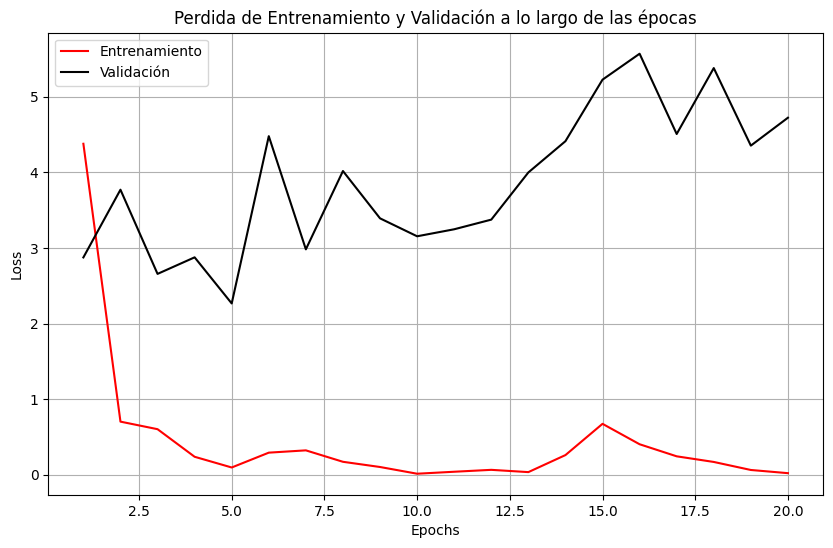

In [ ]:
plt.figure(figsize=(10,6))

plt.plot(range(1, len(train_loss)+1),train_loss, color='r')
plt.plot(range(1, len(train_loss)+1),val_loss, color='black')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Perdida de Entrenamiento y Validación a lo largo de las épocas')
plt.grid(True)
plt.legend(['Entrenamiento', 'Validación'])
plt.show()

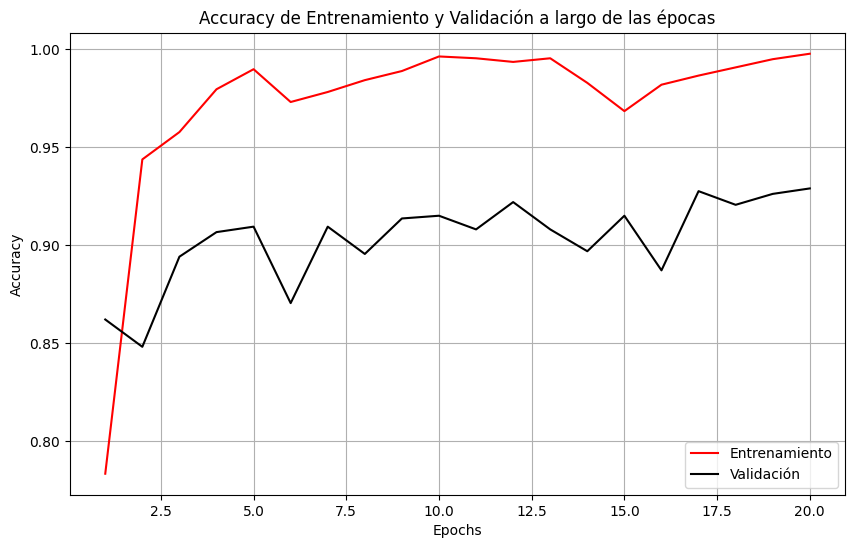

In [ ]:
plt.figure(figsize=(10,6))

plt.plot(range(1,len(train_acc) + 1 ),train_acc, color='r')
plt.plot(range(1,len(train_acc) + 1),val_acc, color='black')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy de Entrenamiento y Validación a largo de las épocas')
plt.grid(True)
plt.legend(['Entrenamiento','Validación'])
plt.show()

Podemos observar que cuando corremos el modelo por 20 epocas sin ejecutar Early Stoppin el modelo muestre aun que no es efiiciente y lo marcado que es el overfitting.

Ahora realizaremos un fine tuning completo, utilizando todas la arquitectura de la VGG16 pero entrenando todas sus capas con nuestros datos. Tambien modificamos la cabeza de clasificación como en los anteriores modelos para que pueda clasificar nuestras 4 targets.

In [ ]:
# Cargamos layers a modelo
model = Sequential()
for layer in vgg16_model.layers:
    model.add(layer)

# Congelamos las capas de VGG16
for layer in model.layers:
    layer.trainable = True
# Incorporamos cabeza de clasificación de 4 clases
model.add(Flatten())
model.add(Dense(4, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

In [ ]:
model_name='vgg16_ft_noaug_es'

callbacks=create_callbacks(model_name)

In [ ]:
history_vgg16_ft = model.fit(
    X_train_vgg16, y_train_vgg16,
    validation_data=[X_valid_vgg16, y_valid_vgg16],
    batch_size=64,
    epochs=40,
    callbacks=callbacks
)

Epoch 1/40
34/34 [==============================] - ETA: 0s - loss: 3.7803 - accuracy: 0.2830Epoch 1: Loss: 3.7803, Accuracy: 0.2830, Val Loss: 1.3623, Val Accuracy: 0.2939

Epoch 1: val_accuracy improved from -inf to 0.29387, saving model to /content/drive/MyDrive/TP FINAL VCII/vgg16_ft_noaug_es_best_model.h5
34/34 [==============================] - 95s 2s/step - loss: 3.7803 - accuracy: 0.2830 - val_loss: 1.3623 - val_accuracy: 0.2939
Epoch 2/40
34/34 [==============================] - ETA: 0s - loss: 1.2951 - accuracy: 0.3852Epoch 2: Loss: 1.2951, Accuracy: 0.3852, Val Loss: 1.2213, Val Accuracy: 0.4331

Epoch 2: val_accuracy improved from 0.29387 to 0.43315, saving model to /content/drive/MyDrive/TP FINAL VCII/vgg16_ft_noaug_es_best_model.h5
34/34 [==============================] - 41s 1s/step - loss: 1.2951 - accuracy: 0.3852 - val_loss: 1.2213 - val_accuracy: 0.4331
Epoch 3/40
34/34 [==============================] - ETA: 0s - loss: 1.1257 - accuracy: 0.4809Epoch 3: Loss: 1.1257,

In [ ]:
history_save_path = '/content/drive/MyDrive/TP FINAL VCII/history_vgg16_noaug_es_20.pkl'
weights_save_path="/content/drive/MyDrive/TP FINAL VCII/weights_vgg16_noaug_es_20.h5"

# Guarda history
with open(history_save_path, 'wb') as f:
    pickle.dump(history_vgg16_ft.history, f)
print(f"History guardado en {history_save_path}")

# Guardar weights
model.save_weights(weights_save_path)
print(f"Pesos guardado en {weights_save_path}")

History guardado en /content/drive/MyDrive/TP FINAL VCII/history_vgg16_noaug_es_20.pkl
Pesos guardado en /content/drive/MyDrive/TP FINAL VCII/weights_vgg16_noaug_es_20.h5


In [ ]:
train_loss=history_vgg16_ft.history['loss']
train_acc=history_vgg16_ft.history['accuracy']
val_loss=history_vgg16_ft.history['val_loss']
val_acc=history_vgg16_ft.history['val_accuracy']

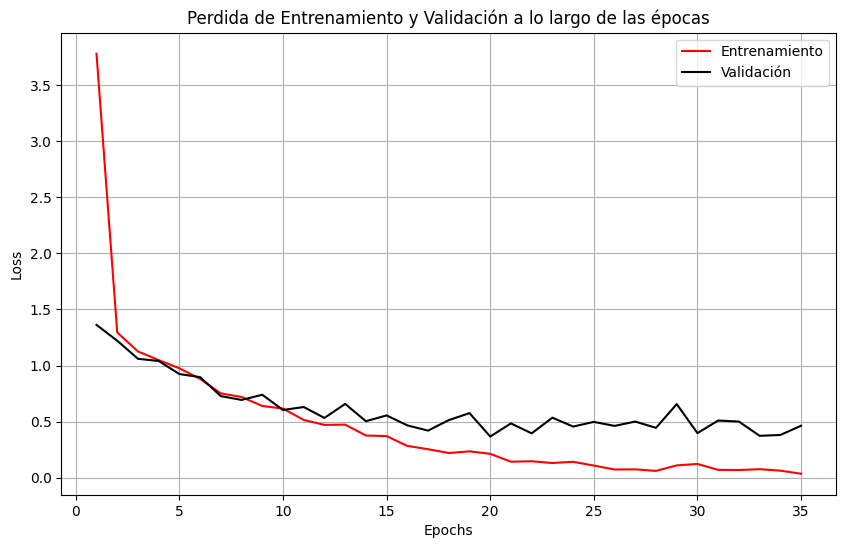

In [ ]:
plt.figure(figsize=(10,6))

plt.plot(range(1, len(train_loss)+1),train_loss, color='r')
plt.plot(range(1, len(train_loss)+1),val_loss, color='black')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Perdida de Entrenamiento y Validación a lo largo de las épocas')
plt.grid(True)
plt.legend(['Entrenamiento', 'Validación'])
plt.show()

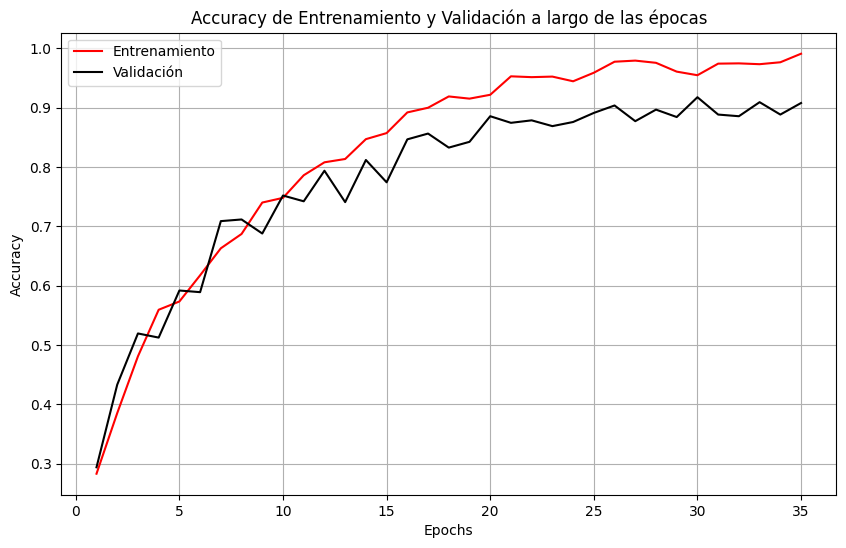

In [ ]:
plt.figure(figsize=(10,6))

plt.plot(range(1,len(train_acc) + 1 ),train_acc, color='r')
plt.plot(range(1,len(train_acc) + 1),val_acc, color='black')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy de Entrenamiento y Validación a largo de las épocas')
plt.grid(True)
plt.legend(['Entrenamiento','Validación'])
plt.show()

Con este nuevo enfoque podemos ver que el modelo practicamente no overfittea por lo que podemos ver como performa en nuestro datos de test para predecir tipo de tumores.

In [ ]:
from sklearn.metrics import classification_report

# Evaluar el modelo en el conjunto de prueba
scores = model.evaluate(X_test_vgg16, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test_vgg16, batch_size=32, verbose=1)

# Convertir las predicciones a las etiquetas de clase
y_pred_bool = np.argmax(y_pred, axis=1)

# Imprimir el reporte de clasificación
print(classification_report(y_test, y_pred_bool))


13/13 [==============================] - 2s 110ms/step - loss: 6.9296 - accuracy: 0.6980
Test loss: 6.929643630981445
Test accuracy: 0.6979695558547974
13/13 [==============================] - 1s 108ms/step
              precision    recall  f1-score   support

           0       0.75      0.21      0.33       100
           1       0.69      0.93      0.80       115
           2       0.62      0.94      0.75       105
           3       0.91      0.65      0.76        74

    accuracy                           0.70       394
   macro avg       0.74      0.68      0.66       394
weighted avg       0.73      0.70      0.66       394



**Métricas Generales:**

- Test Loss: 6.93
- Test Accuracy: 69.8%

**Informe de Clasificación:**

- Precision: capacidad del modelo para identificar correctamente las muestras positivas para cada clase. En general, los valores de precisión para cada clase varían entre 0.62 (clase 2) y 0.91 (clase 3).
- Recall: capacidad del modelo para encontrar todas las muestras positivas para cada clase. Los valores de recuperación varían entre 0.21 (clase 0) y 0.94 (clase 2).
- F1-score: esta es una métrica muy utilizada en problemas en los que el conjunto de datos a analizar está desbalanceado. Esta métrica combina el precision y el recall, para obtener un valor mucho más objetivo. Los valores oscilan entre 0.33 (clase 0) y 0.80 (clase 1).
- Support: El número de muestras reales para cada clase.

**Desempeño por Clase**

**Clase 0:**

1. Precisión: 0.75

Cuando el modelo predice la clase 0, tiene un 75% de probabilidad de que la predicción sea correcta.

2. Recall: 0.21

Solo el 21% de los ejemplos reales de la clase 0 se identifican correctamente.
El modelo está perdiendo muchos ejemplos de la clase 0.

3. F1-Score: 0.33

El equilibrio entre precisión y recall es bajo. La baja tasa de recall afecta negativamente al F1-score, sugiriendo que la clase 0 no está bien representada por el modelo.

**Clase 1:**

1. Precisión: 0.69

Cuando el modelo predice la clase 1, tiene un 69% de probabilidad de que la predicción sea correcta.

2. Recall: 0.93

El modelo identifica correctamente el 93% de los ejemplos reales de la clase 1, lo que indica una alta capacidad para detectar esta clase.

3. F1-Score: 0.80

El equilibrio entre precisión y recall es alto, lo que sugiere que el modelo maneja bien la clase 1 en términos generales.

**Clase 2:**

1. Precisión: 0.62

Cuando el modelo predice la clase 2, tiene un 62% de probabilidad de que la predicción sea correcta.

2. Recall: 0.94

El modelo identifica correctamente el 94% de los ejemplos reales de la clase 2, indicando una alta capacidad para detectar esta clase.

3. F1-Score: 0.75

El equilibrio entre precisión y recall es relativamente alto, pero hay margen de mejora en precisión para esta clase.

**Clase 3:**

1. Precisión: 0.91

Cuando el modelo predice la clase 3, tiene un 91% de probabilidad de que la predicción sea correcta.

2. Recall: 0.65

El modelo identifica correctamente el 65% de los ejemplos reales de la clase 3, lo que indica que no está detectando todos los ejemplos de esta clase.

3. F1-Score: 0.76

El equilibrio entre precisión y recall es bueno, pero podría mejorarse al aumentar el recall




**Conclusiones Generales Adicionales:**

**Accuracy**: 0.70

El modelo clasifica correctamente el 70% de las muestras en el conjunto de prueba.

**Macro Average:**

* Precisión: 0.74

En promedio, cuando el modelo predice una clase, tiene un 74% de probabilidad de que la predicción sea correcta.
* Recall: 0.68

En promedio, el modelo identifica correctamente el 68% de los ejemplos reales de cada clase. Esto sugiere que el modelo tiene un rendimiento razonable en general, pero algunas clases pueden no estar bien representadas.

* F1-Score: 0.66

En promedio, el equilibrio entre precisión y recall es moderado. El F1-score más bajo indica que hay clases con una menor capacidad de detección o precisión.

**Weighted Average (Promedio Ponderado):**

* Precisión: 0.73

El promedio ponderado de la precisión de todas las clases es del 73%. Esto toma en cuenta el soporte (número de ocurrencias de cada clase).

* Recall: 0.70

El promedio ponderado de recall de todas las clases es del 70%, lo que sugiere que el modelo tiene un rendimiento equilibrado pero con margen de mejora en la detección de todas las clases.

* F1-Score: 0.66

 El F1-score ponderado es del 66%, lo que indica un rendimiento moderado en general, considerando el equilibrio entre precisión y recall para todas las clases.

##Resnet

Plantearemos un transfer learning (feature extraction) con Resnet y modificando el cabezal para resolver nuestro problema. Aplicaremos regularización en capas densas.

In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input,ResNet50

X_train_resnet50 = preprocess_input(X_train)
X_test_resnet50 = preprocess_input(X_test)

# Armamos sets de validación

from sklearn.model_selection import train_test_split

X_train_resnet50, X_valid_resnet50, y_train_resnet50, y_valid_resnet50=train_test_split(X_train_resnet50,y_train, test_size=0.25, random_state=74,stratify=y_train)


In [ ]:
# Callbacks

from tensorflow.keras.callbacks import LambdaCallback, EarlyStopping, ModelCheckpoint

def create_callbacks(model_name):
    # Callback para imprimir la pérdida y la métrica en cada época
    print_epoch_callback = LambdaCallback(
        on_epoch_end=lambda epoch, logs: print(
            f"Epoch {epoch + 1}: Loss: {logs['loss']:.4f}, Accuracy: {logs.get('accuracy', 'N/A'):.4f}, "
            f"Val Loss: {logs['val_loss']:.4f}, Val Accuracy: {logs.get('val_accuracy', 'N/A'):.4f}"
        )
    )

    # Callback de EarlyStopping para monitorear la métrica de validación
    es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5)

    #  Callback de ModelCheckpoint para guardar el mejor modelo
    mc = ModelCheckpoint(f'/content/drive/MyDrive/TP FINAL VCII/{model_name}_best_model.keras', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

    return [print_epoch_callback, es, mc]

In [ ]:
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [ ]:
# Congelamos todo los bloque conv
for layer in resnet_model.layers:
    layer.trainable=False

# Creamos nuevo modelo con cabezal de clasificación de 4 clases
input=Input(shape=(224,224,3))
x=resnet_model(input,training=False)
x=Flatten()(x)
#x=Dense(128, activation='relu', kernel_regularizer='l2')(x)
#x=Dropout(0.5)(x)
#x=BatchNormalization()(x)
output=Dense(4, activation='softmax')(x)
model=Model(input, output)


In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model_name='resnet50_tl_noaug_es'

callbacks=create_callbacks(model_name)

In [ ]:
history_resnet50_tl_noaug_es = model.fit(
    X_train_resnet50, y_train_resnet50,
    validation_data=[X_valid_resnet50, y_valid_resnet50],
    batch_size=64,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.5010 - loss: 14.9382Epoch 1: Loss: 9.6837, Accuracy: 0.6645, Val Loss: 3.9449, Val Accuracy: 0.8496

Epoch 1: val_accuracy improved from -inf to 0.84958, saving model to /content/drive/MyDrive/TP FINAL VCII/resnet50_tl_noaug_es_best_model.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 32s 663ms/step - accuracy: 0.5056 - loss: 14.7881 - val_accuracy: 0.8496 - val_loss: 3.9449
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.9232 - loss: 1.2857Epoch 2: Loss: 1.0271, Accuracy: 0.9275, Val Loss: 1.7532, Val Accuracy: 0.8844

Epoch 2: val_accuracy improved from 0.84958 to 0.88440, saving model to /content/drive/MyDrive/TP FINAL VCII/resnet50_tl_noaug_es_best_model.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 27s 354ms/step - accuracy: 0.9234 - loss: 1.2783 - val_accuracy: 0.8844 - val_loss: 1.7532
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.9704 - loss: 0.1850Epoch 3: Loss: 0.1732, Accuracy: 0.9726, Val Loss: 1.5

In [ ]:
history_save_path = '/content/drive/MyDrive/TP FINAL VCII/history_resnet50_tl_noaug_es.pkl'
weights_save_path="/content/drive/MyDrive/TP FINAL VCII/weights_resnet50_tl_noaug_es.weights.h5"

# Guarda history
with open(history_save_path, 'wb') as f:
    pickle.dump(history_resnet50_tl_noaug_es.history, f)
print(f"History guardado en {history_save_path}")

# Guardar weights
model.save_weights(weights_save_path)
print(f"Pesos guardado en {weights_save_path}")

History guardado en /content/drive/MyDrive/TP FINAL VCII/history_resnet50_tl_noaug_es.pkl
Pesos guardado en /content/drive/MyDrive/TP FINAL VCII/weights_resnet50_tl_noaug_es.weights.h5


In [ ]:
train_loss=history_resnet50_tl_noaug_es.history['loss']
train_acc=history_resnet50_tl_noaug_es.history['accuracy']
val_loss=history_resnet50_tl_noaug_es.history['val_loss']
val_acc=history_resnet50_tl_noaug_es.history['val_accuracy']

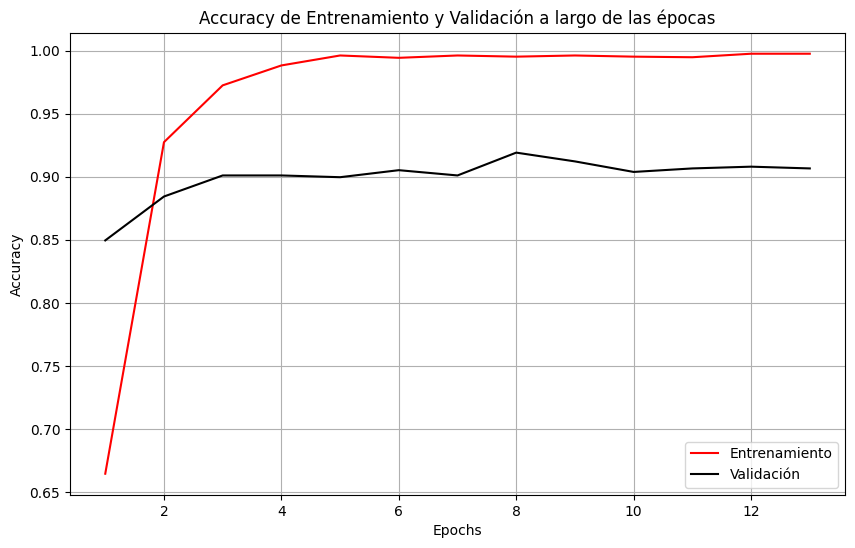

In [ ]:
plt.figure(figsize=(10,6))

plt.plot(range(1,len(train_acc) + 1 ),train_acc, color='r')
plt.plot(range(1,len(train_acc) + 1),val_acc, color='black')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy de Entrenamiento y Validación a largo de las épocas')
plt.grid(True)
plt.legend(['Entrenamiento','Validación'])
plt.show()

Vemos que el modelo para por early stopping por no mejorar la métrica de validación por 5 epochs pero vemos que se mantuvo bastante parejo por lo que vamos a dejar el modelo correr 20 epochs para ver si el mismo puede mejorar un poco mas.

In [ ]:
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [ ]:
# Congelamos todo los bloque conv
for layer in resnet_model.layers:
    layer.trainable=False

# Creamos nuevo modelo con cabezal de clasificación de 4 clases
input=Input(shape=(224,224,3))
x=resnet_model(input,training=False)
x=Flatten()(x)
#x=Dense(128, activation='relu', kernel_regularizer='l2')(x)
#x=Dropout(0.5)(x)
#x=BatchNormalization()(x)
output=Dense(4, activation='softmax')(x)
model=Model(input, output)

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [18]:
# Definimos unicamente los callbacks a ejecutar

print_epoch_callback = LambdaCallback(
  on_epoch_end=lambda epoch, logs: print(
    f"Epoch {epoch + 1}: Loss: {logs['loss']:.4f}, Accuracy: {logs.get('accuracy', 'N/A'):.4f}, "
    f"Val Loss: {logs['val_loss']:.4f}, Val Accuracy: {logs.get('val_accuracy', 'N/A'):.4f}"
  )
)


mc = ModelCheckpoint(f'/content/drive/MyDrive/TP FINAL VCII/{model_name}_best_model.keras', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)



In [ ]:
model_name='resnet50_tl_noaug'

In [ ]:
history_resnet50_tl_noaug = model.fit(
    X_train_resnet50, y_train_resnet50,
    validation_data=[X_valid_resnet50, y_valid_resnet50],
    batch_size=64,
    epochs=20,
    callbacks=[print_epoch_callback,mc]
)

Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.5414 - loss: 12.5888Epoch 1: Loss: 7.7114, Accuracy: 0.6901, Val Loss: 2.3104, Val Accuracy: 0.8705

Epoch 1: val_accuracy improved from -inf to 0.87047, saving model to /content/drive/MyDrive/TP FINAL VCII/resnet50_tl_noaug_reg_best_model.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 36s 793ms/step - accuracy: 0.5457 - loss: 12.4494 - val_accuracy: 0.8705 - val_loss: 2.3104
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.9133 - loss: 1.0886Epoch 2: Loss: 0.9663, Accuracy: 0.9233, Val Loss: 1.4000, Val Accuracy: 0.8997

Epoch 2: val_accuracy improved from 0.87047 to 0.89972, saving model to /content/drive/MyDrive/TP FINAL VCII/resnet50_tl_noaug_reg_best_model.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 578ms/step - accuracy: 0.9136 - loss: 1.0851 - val_accuracy: 0.8997 - val_loss: 1.4000
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.9810 - loss: 0.1479Epoch 3: Loss: 0.1789, Accuracy: 0.9768, Val Loss: 1

In [ ]:
history_save_path = '/content/drive/MyDrive/TP FINAL VCII/history_resnet50_tl_noaug.pkl'
weights_save_path="/content/drive/MyDrive/TP FINAL VCII/weights_resnet50_tl_noaug.weights.h5"

# Guarda history
with open(history_save_path, 'wb') as f:
    pickle.dump(history_resnet50_tl_noaug.history, f)
print(f"History guardado en {history_save_path}")

# Guardar weights
model.save_weights(weights_save_path)
print(f"Pesos guardado en {weights_save_path}")

History guardado en /content/drive/MyDrive/TP FINAL VCII/history_resnet50_tl_noaug.pkl
Pesos guardado en /content/drive/MyDrive/TP FINAL VCII/weights_resnet50_tl_noaug.weights.h5


In [ ]:
history_resnet50_tl_noaug

In [ ]:
train_loss=history_resnet50_tl_noaug.history['loss']
train_acc=history_resnet50_tl_noaug.history['accuracy']
val_loss=history_resnet50_tl_noaug.history['val_loss']
val_acc=history_resnet50_tl_noaug.history['val_accuracy']

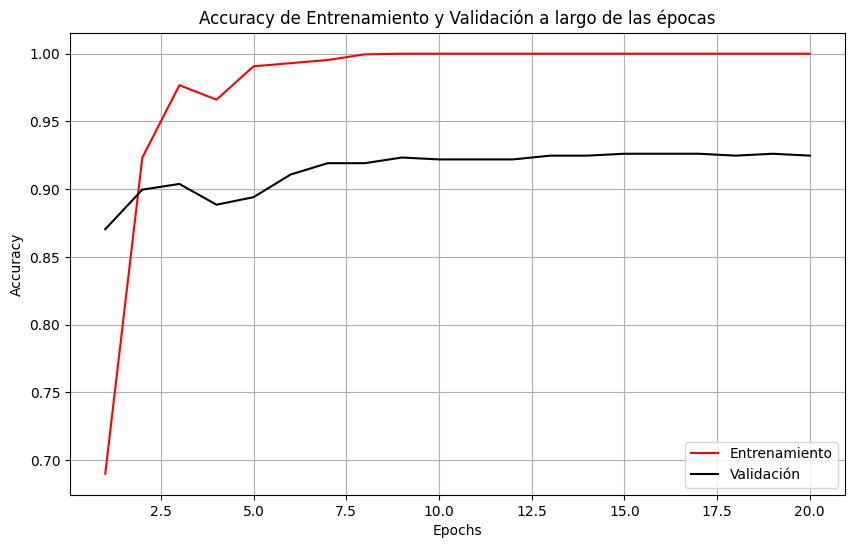

In [ ]:
plt.figure(figsize=(10,6))

plt.plot(range(1,len(train_acc) + 1 ),train_acc, color='r')
plt.plot(range(1,len(train_acc) + 1),val_acc, color='black')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy de Entrenamiento y Validación a largo de las épocas')
plt.grid(True)
plt.legend(['Entrenamiento','Validación'])
plt.show()

Podemos observar que el modelo mantiene un buen comportamiento en el set de validación a traves de las epocas con un pequeño overfitting.

In [ ]:
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
resnet_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
# Congelamos todo los bloque conv
for layer in resnet_model.layers:
    layer.trainable=True

# Creamos nuevo modelo con cabezal de clasificación de 4 clases
input=Input(shape=(224,224,3))
x=resnet_model(input,training=False)
x=Flatten()(x)
#x=Dense(128, activation='relu', kernel_regularizer='l2')(x)
#x=Dropout(0.5)(x)
#x=BatchNormalization()(x)
output=Dense(4, activation='softmax')(x)
model=Model(input, output)

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4)                   │         401,412 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,989,124 (91.51 MB)

 Trainable params: 23,936,004 (91.31 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model_name='resnet50_ft_noaug_es'

callbacks=create_callbacks(model_name)

In [ ]:
history_resnet50_ft_noaug_es = model.fit(
    X_train_resnet50, y_train_resnet50,
    validation_data=[X_valid_resnet50, y_valid_resnet50],
    batch_size=64,
    epochs=35,
    callbacks=callbacks
)

Epoch 1/35
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5755 - loss: 7.1294   Epoch 1: Loss: 4.3704, Accuracy: 0.6817, Val Loss: 379056.5312, Val Accuracy: 0.2883

Epoch 1: val_accuracy improved from -inf to 0.28830, saving model to /content/drive/MyDrive/TP FINAL VCII/resnet50_ft_noaug_es_best_model.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step - accuracy: 0.5786 - loss: 7.0505 - val_accuracy: 0.2883 - val_loss: 379056.5312
Epoch 2/35
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 534ms/step - accuracy: 0.8051 - loss: 1.9528Epoch 2: Loss: 0.9508, Accuracy: 0.8206, Val Loss: 74514.2031, Val Accuracy: 0.2897

Epoch 2: val_accuracy improved from 0.28830 to 0.28969, saving model to /content/drive/MyDrive/TP FINAL VCII/resnet50_ft_noaug_es_best_model.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.8055 - loss: 1.9242 - val_accuracy: 0.2897 - val_loss: 74514.2031
Epoch 3/35
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 539ms/step - accuracy: 0.9053 - loss: 0.4851Epoch 3: Loss: 0.9509, Accuracy: 0.8629, Va

In [ ]:
history_save_path = '/content/drive/MyDrive/TP FINAL VCII/history_resnet50_ft_noaug_es.pkl'
weights_save_path="/content/drive/MyDrive/TP FINAL VCII/weights_resnet50_ft_noaug_es.weights.h5"

# Guarda history
with open(history_save_path, 'wb') as f:
    pickle.dump(history_resnet50_ft_noaug_es.history, f)
print(f"History guardado en {history_save_path}")

# Guardar weights
model.save_weights(weights_save_path)
print(f"Pesos guardado en {weights_save_path}")

History guardado en /content/drive/MyDrive/TP FINAL VCII/history_resnet50_ft_noaug_es.pkl
Pesos guardado en /content/drive/MyDrive/TP FINAL VCII/weights_resnet50_ft_noaug_es.weights.h5


In [ ]:
train_loss=history_resnet50_ft_noaug_es.history['loss']
train_acc=history_resnet50_ft_noaug_es.history['accuracy']
val_loss=history_resnet50_ft_noaug_es.history['val_loss']
val_acc=history_resnet50_ft_noaug_es.history['val_accuracy']

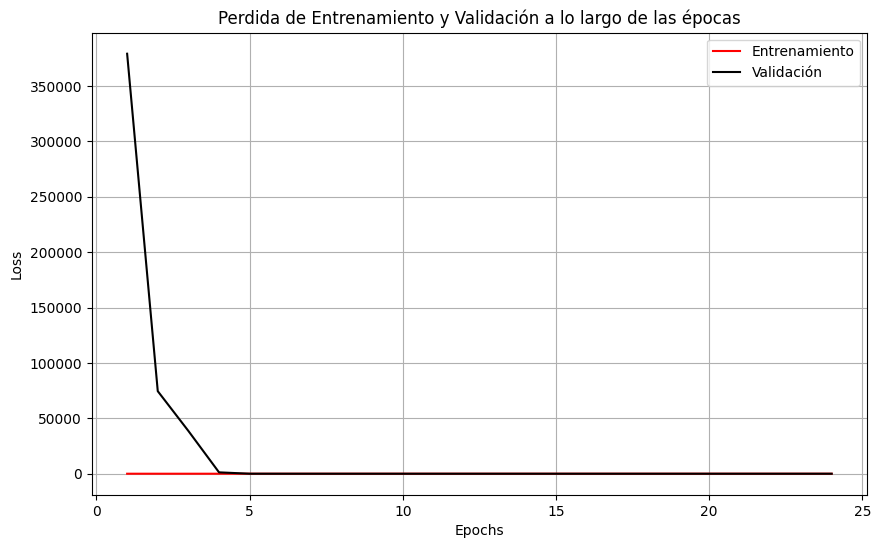

In [ ]:
plt.figure(figsize=(10,6))

plt.plot(range(1, len(train_loss)+1),train_loss, color='r')
plt.plot(range(1, len(train_loss)+1),val_loss, color='black')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Perdida de Entrenamiento y Validación a lo largo de las épocas')
plt.grid(True)
plt.legend(['Entrenamiento', 'Validación'])
plt.show()

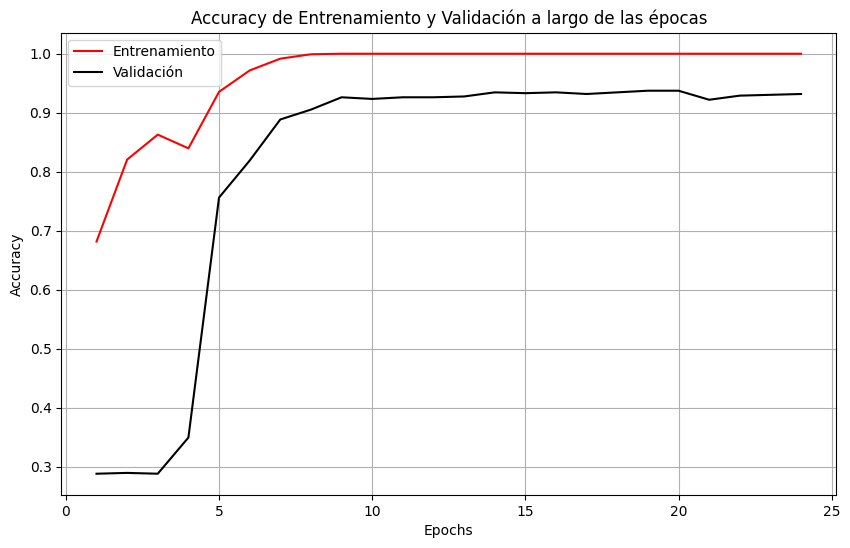

In [ ]:
plt.figure(figsize=(10,6))

plt.plot(range(1,len(train_acc) + 1 ),train_acc, color='r')
plt.plot(range(1,len(train_acc) + 1),val_acc, color='black')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy de Entrenamiento y Validación a largo de las épocas')
plt.grid(True)
plt.legend(['Entrenamiento','Validación'])
plt.show()

Podemos observar que al realizar un fine tuning y dejando entrenar el modelo por 24 epochs (se detuvo por early stoppin) el modelo no presente overfitting entre el conjunto de train y validation. Usaremos este ultimo modelo para evaluar en test y ver cuales son las metricas para un conjunto de imagenes que nunco observo.

In [ ]:
from sklearn.metrics import classification_report

# Evaluar el modelo en el conjunto de prueba
scores = model.evaluate(X_test_resnet50, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test_resnet50, batch_size=32, verbose=1)

# Convertir las predicciones a las etiquetas de clase
y_pred_bool = np.argmax(y_pred, axis=1)

# Imprimir el reporte de clasificación
print(classification_report(y_test, y_pred_bool))

13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 337ms/step - accuracy: 0.7125 - loss: 3.8113
Test loss: 4.072200775146484
Test accuracy: 0.682741105556488
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 340ms/step
              precision    recall  f1-score   support

           0       0.95      0.18      0.30       100
           1       0.65      0.90      0.75       115
           2       0.61      0.96      0.75       105
           3       0.96      0.62      0.75        74

    accuracy                           0.68       394
   macro avg       0.79      0.67      0.64       394
weighted avg       0.77      0.68      0.64       394



**Métricas Generales**:

- Test Loss: 4.0722
- Test Accuracy: 68.3%

**Informe de Clasificación:**

- Precision: capacidad del modelo para identificar correctamente las muestras positivas para cada clase. Los valores de precisión para cada clase varían entre 0.61 (clase 2) y 0.96 (clases 0 y 3).
- Recall: capacidad del modelo para encontrar todas las muestras positivas para cada clase. Los valores de recall varían entre 0.18 (clase 0) y 0.96 (clase 2).
- F1-score: combina la precisión y el recall para obtener un valor más objetivo. Los valores oscilan entre 0.30 (clase 0) y 0.75 (clases 1, 2 y 3).

**Desempeño por Clase:**

**Clase 0:**

1- Precisión: 0.95

Cuando el modelo predice la clase 0, tiene un 95% de probabilidad de que la predicción sea correcta.

2- Recall: 0.18

Solo el 18% de los ejemplos reales de la clase 0 se identifican correctamente.
El modelo está perdiendo muchos ejemplos de la clase 0.

3- F1-Score: 0.30

El equilibrio entre precisión y recall es bajo. La baja tasa de recall afecta negativamente al F1-score, sugiriendo que la clase 0 no está bien representada por el modelo.

**Clase 1:**

1- Precisión: 0.65

Cuando el modelo predice la clase 1, tiene un 65% de probabilidad de que la predicción sea correcta.

2- Recall: 0.90

El modelo identifica correctamente el 90% de los ejemplos reales de la clase 1, lo que indica una alta capacidad para detectar esta clase.

3 - F1-Score: 0.75

El equilibrio entre precisión y recall es alto, lo que sugiere que el modelo maneja bien la clase 1 en términos generales.

**Clase 2:**

1- Precisión: 0.61

Cuando el modelo predice la clase 2, tiene un 61% de probabilidad de que la predicción sea correcta.

2- Recall: 0.96

El modelo identifica correctamente el 96% de los ejemplos reales de la clase 2, indicando una alta capacidad para detectar esta clase.

3- F1-Score: 0.75

El equilibrio entre precisión y recall es relativamente alto, pero hay margen de mejora en precisión para esta clase.

**Clase 3:**

1- Precisión: 0.96

Cuando el modelo predice la clase 3, tiene un 96% de probabilidad de que la predicción sea correcta.

2- Recall: 0.62

El modelo identifica correctamente el 62% de los ejemplos reales de la clase 3, lo que indica que no está detectando todos los ejemplos de esta clase.

3- F1-Score: 0.75

El equilibrio entre precisión y recall es bueno, pero podría mejorarse al aumentar el recall.

**Conclusiones Generales Adicionales:**

- Accuracy: 0.68

El modelo clasifica correctamente el 68% de las muestras en el conjunto de prueba.

**Macro Average:**

* Precisión: 0.79

En promedio, cuando el modelo predice una clase, tiene un 79% de probabilidad de que la predicción sea correcta.

* Recall: 0.67

En promedio, el modelo identifica correctamente el 67% de los ejemplos reales de cada clase. Esto sugiere que el modelo tiene un rendimiento razonable en general, pero algunas clases pueden no estar bien representadas.

* F1-Score: 0.64

En promedio, el equilibrio entre precisión y recall es moderado. El F1-score más bajo indica que hay clases con una menor capacidad de detección o precisión.
Weighted Average

**Promedio Ponderado:**

Esto toma en cuenta el soporte (número de ocurrencias de cada clase).

* Precisión: 0.77

El promedio ponderado de la precisión de todas las clases es del 77%.

* Recall: 0.68

El promedio ponderado de recall de todas las clases es del 68%, lo que sugiere que el modelo tiene un rendimiento equilibrado pero con margen de mejora en la detección de todas las clases.

* F1-Score: 0.64

El F1-score ponderado es del 64%, lo que indica un rendimiento moderado en general, considerando el equilibrio entre precisión y recall para todas las clases.

## Inception

In [9]:
# Normalización de X_train y X_test

X_train_inception = preprocess_input(X_train)
X_test_inception = preprocess_input(X_test)

# Armamos sets de validación

from sklearn.model_selection import train_test_split

X_train_inception, X_valid_inception, y_train_inception, y_valid_inception=train_test_split(X_train_inception,y_train, test_size=0.25, random_state=74,stratify=y_train)

In [17]:
X_train_inception.shape

(2152, 224, 224, 3)

In [ ]:
inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
inception_model.summary()

Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 111, 111, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 111, 111, 32)   │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 111, 111, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 109, 109, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 109, 109, 32)   │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 109, 109, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 109, 109, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 109, 109, 64)   │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 109, 109, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 54, 54, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 54, 54, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 54, 54, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 54, 54, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 52, 52, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 52, 52, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 21,768,352 (83.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [ ]:
# Congelamos todo los bloque conv
for layer in inception_model.layers:
    layer.trainable=False

# Creamos nuevo modelo con cabezal de clasificación de 4 clases
input=Input(shape=(224,224,3))
x=inception_model(input,training=False)
x=Flatten()(x)
output=Dense(4, activation='softmax')(x)
model=Model(input, output)

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_v3 (Functional)            │ (None, 5, 5, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4)                   │         204,804 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,007,588 (83.95 MB)

 Trainable params: 204,804 (800.02 KB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

In [ ]:
model_name='inception_tl_noaug_es'

callbacks=create_callbacks(model_name)

In [ ]:
history_inception_tl_noaug_es=model.fit(
    X_train_inception,y_train_inception,
    validation_data=[X_valid_inception, y_valid_inception],
    batch_size=64,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step - accuracy: 0.4367 - loss: 9.5306Epoch 1: Loss: 6.0559, Accuracy: 0.5743, Val Loss: 1.3111, Val Accuracy: 0.8106

Epoch 1: val_accuracy improved from -inf to 0.81058, saving model to /content/drive/MyDrive/TP FINAL VCII/inception_tl_noaug_es_best_model.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.4406 - loss: 9.4313 - val_accuracy: 0.8106 - val_loss: 1.3111
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.8570 - loss: 0.8583Epoch 2: Loss: 0.7645, Accuracy: 0.8634, Val Loss: 0.9484, Val Accuracy: 0.8510

Epoch 2: val_accuracy improved from 0.81058 to 0.85097, saving model to /content/drive/MyDrive/TP FINAL VCII/inception_tl_noaug_es_best_model.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 31s 311ms/step - accuracy: 0.8572 - loss: 0.8557 - val_accuracy: 0.8510 - val_loss: 0.9484
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9247 - loss: 0.2603Epoch 3: Loss: 0.2325, Accuracy: 0.9289, Val Loss: 0.6726

In [ ]:
history_save_path = '/content/drive/MyDrive/TP FINAL VCII/history_inception_tl_noaug_es.pkl'
weights_save_path="/content/drive/MyDrive/TP FINAL VCII/weights_inception_tl_noaug_es.weights.h5"

# Guarda history
with open(history_save_path, 'wb') as f:
    pickle.dump(history_inception_tl_noaug_es.history, f)
print(f"History guardado en {history_save_path}")

# Guardar weights
model.save_weights(weights_save_path)
print(f"Pesos guardado en {weights_save_path}")

History guardado en /content/drive/MyDrive/TP FINAL VCII/history_inception_tl_noaug_es.pkl
Pesos guardado en /content/drive/MyDrive/TP FINAL VCII/weights_inception_tl_noaug_es.weights.h5


In [ ]:
train_loss=history_inception_tl_noaug_es.history['loss']
train_acc=history_inception_tl_noaug_es.history['accuracy']
val_loss=history_inception_tl_noaug_es.history['val_loss']
val_acc=history_inception_tl_noaug_es.history['val_accuracy']

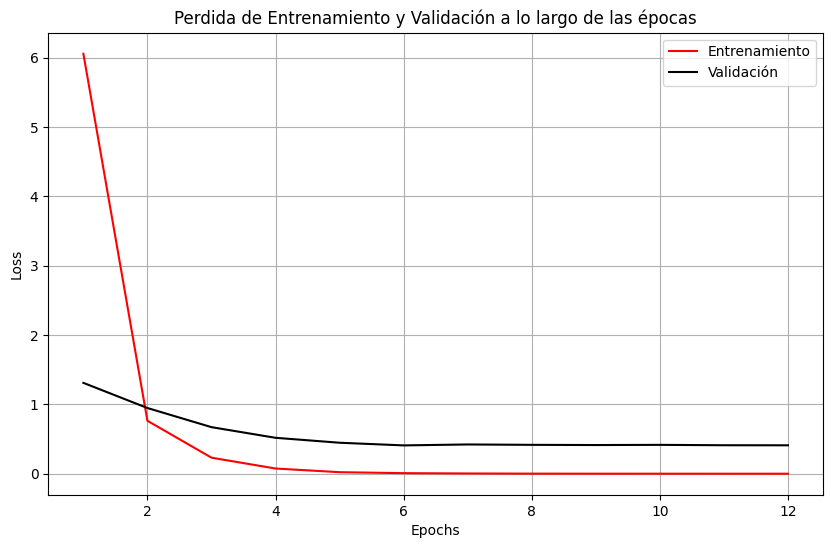

In [ ]:
plt.figure(figsize=(10,6))

plt.plot(range(1, len(train_loss)+1),train_loss, color='r')
plt.plot(range(1, len(train_loss)+1),val_loss, color='black')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Perdida de Entrenamiento y Validación a lo largo de las épocas')
plt.grid(True)
plt.legend(['Entrenamiento', 'Validación'])
plt.show()

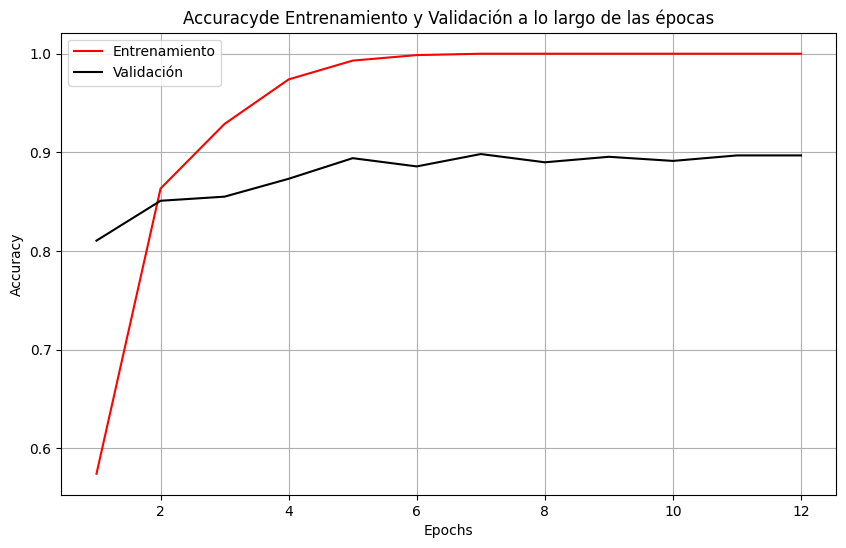

In [ ]:
plt.figure(figsize=(10,6))

plt.plot(range(1, len(train_loss)+1),train_acc, color='r')
plt.plot(range(1, len(train_loss)+1),val_acc, color='black')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.title('Accuracyde Entrenamiento y Validación a lo largo de las épocas')
plt.grid(True)
plt.legend(['Entrenamiento', 'Validación'])
plt.show()

Para monitorear mejor el modelo retiraremos el early stopping y veremos el compartamiento de la perdido y accurracy en 20 epochs

In [ ]:
inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Congelamos todo los bloque conv
for layer in inception_model.layers:
    layer.trainable=False

# Creamos nuevo modelo con cabezal de clasificación de 4 clases
input=Input(shape=(224,224,3))
x=inception_model(input,training=False)
x=Flatten()(x)
output=Dense(4, activation='softmax')(x)
model=Model(input, output)

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

In [ ]:
model_name='inception_tl_noaug'

callbacks=create_callbacks(model_name)

In [ ]:
history_inception_tl_noaug=model.fit(
    X_train_inception,y_train_inception,
    validation_data=[X_valid_inception, y_valid_inception],
    batch_size=64,
    epochs=20,
    callbacks=[print_epoch_callback,mc]
)

Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.4419 - loss: 8.2180Epoch 1: Loss: 5.2610, Accuracy: 0.5939, Val Loss: 1.1695, Val Accuracy: 0.8148

Epoch 1: val_accuracy improved from -inf to 0.81476, saving model to /content/drive/MyDrive/TP FINAL VCII/inception_tl_noaug_best_model.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.4462 - loss: 8.1335 - val_accuracy: 0.8148 - val_loss: 1.1695
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.8288 - loss: 1.0461Epoch 2: Loss: 0.8808, Accuracy: 0.8555, Val Loss: 0.6668, Val Accuracy: 0.8691

Epoch 2: val_accuracy improved from 0.81476 to 0.86908, saving model to /content/drive/MyDrive/TP FINAL VCII/inception_tl_noaug_best_model.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 41s 231ms/step - accuracy: 0.8296 - loss: 1.0414 - val_accuracy: 0.8691 - val_loss: 0.6668
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.9451 - loss: 0.2123Epoch 3: Loss: 0.1809, Accuracy: 0.9475, Val Loss: 0.5413, Val 

In [ ]:
history_save_path = '/content/drive/MyDrive/TP FINAL VCII/history_inception_tl_noaug.pkl'
weights_save_path="/content/drive/MyDrive/TP FINAL VCII/weights_inception_tl_noaug.weights.h5"

# Guarda history
with open(history_save_path, 'wb') as f:
    pickle.dump(history_inception_tl_noaug.history, f)
print(f"History guardado en {history_save_path}")

# Guardar weights
model.save_weights(weights_save_path)
print(f"Pesos guardado en {weights_save_path}")

History guardado en /content/drive/MyDrive/TP FINAL VCII/history_inception_tl_noaug.pkl
Pesos guardado en /content/drive/MyDrive/TP FINAL VCII/weights_inception_tl_noaug.weights.h5


In [ ]:
train_loss=history_inception_tl_noaug.history['loss']
train_acc=history_inception_tl_noaug.history['accuracy']
val_loss=history_inception_tl_noaug.history['val_loss']
val_acc=history_inception_tl_noaug.history['val_accuracy']

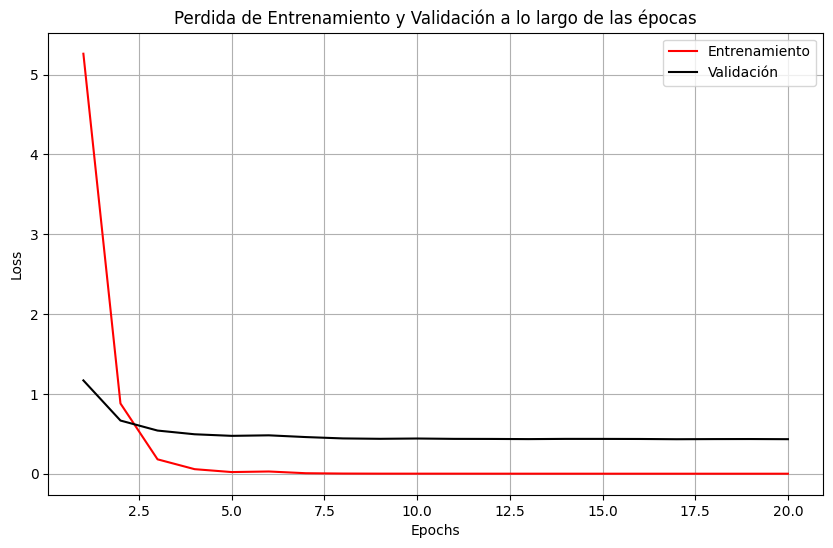

In [ ]:
plt.figure(figsize=(10,6))

plt.plot(range(1, len(train_loss)+1),train_loss, color='r')
plt.plot(range(1, len(train_loss)+1),val_loss, color='black')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Perdida de Entrenamiento y Validación a lo largo de las épocas')
plt.grid(True)
plt.legend(['Entrenamiento', 'Validación'])
plt.show()

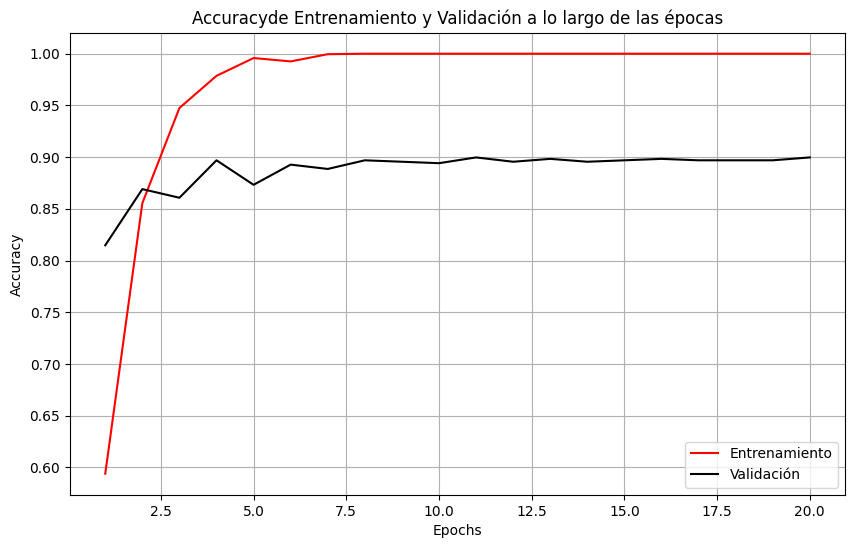

In [ ]:
plt.figure(figsize=(10,6))

plt.plot(range(1, len(train_loss)+1),train_acc, color='r')
plt.plot(range(1, len(train_loss)+1),val_acc, color='black')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.title('Accuracyde Entrenamiento y Validación a lo largo de las épocas')
plt.grid(True)
plt.legend(['Entrenamiento', 'Validación'])
plt.show()

In [20]:
inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Congelamos todo los bloque conv
for layer in inception_model.layers:
    layer.trainable=True

# Creamos nuevo modelo con cabezal de clasificación de 4 clases
input=Input(shape=(224,224,3))
x=inception_model(input,training=False)
x=Flatten()(x)
output=Dense(4, activation='softmax')(x)
model=Model(input, output)

In [21]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [22]:
model_name='inception_ft_noaug_50'

# callbacks=create_callbacks(model_name)

In [23]:
history_inception_ft_noaug_50=model.fit(
    X_train_inception, y_train_inception,
    validation_data=[X_valid_inception,y_valid_inception],
    batch_size=64,
    epochs=40,
    callbacks=[print_epoch_callback,mc]
)

Epoch 1/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5960 - loss: 2.2103   Epoch 1: Loss: 1.0712, Accuracy: 0.7514, Val Loss: 672.5477, Val Accuracy: 0.3120

Epoch 1: val_accuracy improved from -inf to 0.31198, saving model to /content/drive/MyDrive/TP FINAL VCII/inception_ft_noaug_es_best_model.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 207s 3s/step - accuracy: 0.6004 - loss: 2.1778 - val_accuracy: 0.3120 - val_loss: 672.5477
Epoch 2/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.9054 - loss: 0.2769Epoch 2: Loss: 0.2663, Accuracy: 0.9094, Val Loss: 630.6777, Val Accuracy: 0.1379

Epoch 2: val_accuracy did not improve from 0.31198
34/34 ━━━━━━━━━━━━━━━━━━━━ 47s 492ms/step - accuracy: 0.9055 - loss: 0.2766 - val_accuracy: 0.1379 - val_loss: 630.6777
Epoch 3/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.9462 - loss: 0.2056Epoch 3: Loss: 0.2294, Accuracy: 0.9294, Val Loss: 31.3768, Val Accuracy: 0.1379

Epoch 3: val_accuracy did not improve from 0.31198
34/34 ━━━━━━

In [ ]:
history_save_path = '/content/drive/MyDrive/TP FINAL VCII/history_inception_ft_noaug_es.pkl'
weights_save_path="/content/drive/MyDrive/TP FINAL VCII/weights_inception_ft_noaug_es.weights.h5"

# Guarda history
with open(history_save_path, 'wb') as f:
    pickle.dump(history_inception_ft_noaug_50.history, f)
print(f"History guardado en {history_save_path}")

# Guardar weights
model.save_weights(weights_save_path)
print(f"Pesos guardado en {weights_save_path}")

In [24]:
train_loss=history_inception_ft_noaug_50.history['loss']
train_acc=history_inception_ft_noaug_50.history['accuracy']
val_loss=history_inception_ft_noaug_50.history['val_loss']
val_acc=history_inception_ft_noaug_50.history['val_accuracy']

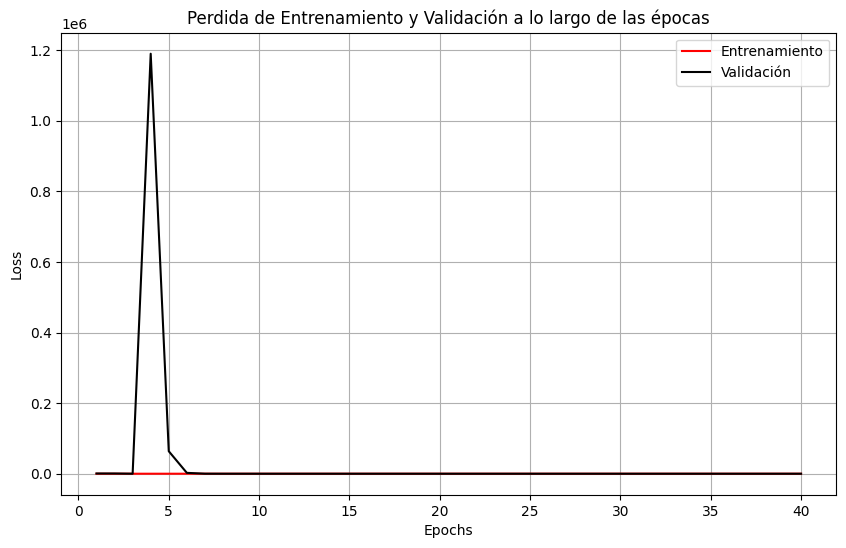

In [25]:
plt.figure(figsize=(10,6))

plt.plot(range(1, len(train_loss)+1),train_loss, color='r')
plt.plot(range(1, len(train_loss)+1),val_loss, color='black')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Perdida de Entrenamiento y Validación a lo largo de las épocas')
plt.grid(True)
plt.legend(['Entrenamiento', 'Validación'])
plt.show()

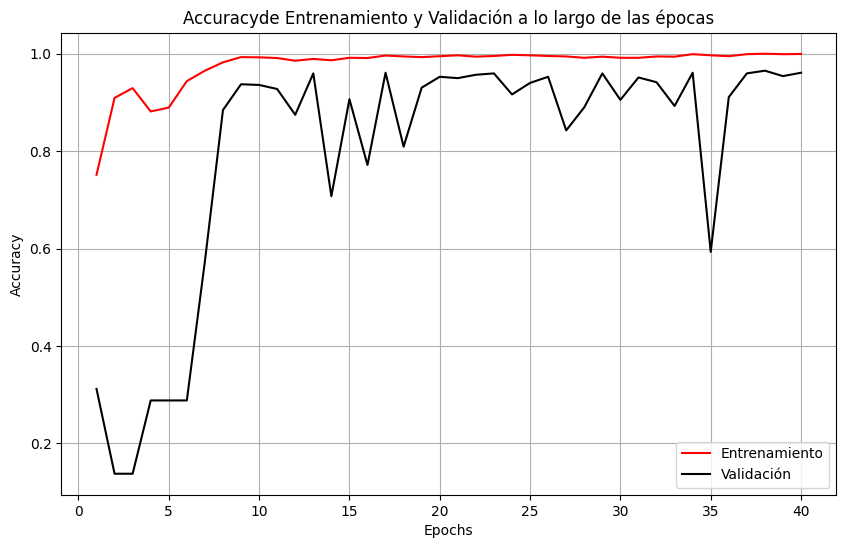

In [26]:
plt.figure(figsize=(10,6))

plt.plot(range(1, len(train_loss)+1),train_acc, color='r')
plt.plot(range(1, len(train_loss)+1),val_acc, color='black')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.title('Accuracyde Entrenamiento y Validación a lo largo de las épocas')
plt.grid(True)
plt.legend(['Entrenamiento', 'Validación'])
plt.show()

Podemos observar que el modelo presenta inestabilidad al realizar descongelar todas las capas y entrenar de cero todas las capas. Se puede ver que epoca a epoca el modelo tienda a mejorar pero que claramente presenta un overfitting en principio puede ser por la complejidad del modelo inception y que el dataset es acotado. De igual manera, utilizaremos este modelo para evaluar en test dado fue el que mejor metrica obtuvo en las 3 opciones probadas con inception.

In [27]:
from sklearn.metrics import classification_report

# Evaluar el modelo en el conjunto de prueba
scores = model.evaluate(X_test_inception, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test_inception, batch_size=32, verbose=1)

# Convertir las predicciones a las etiquetas de clase
y_pred_bool = np.argmax(y_pred, axis=1)

# Imprimir el reporte de clasificación
print(classification_report(y_test, y_pred_bool))

13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 536ms/step - accuracy: 0.7714 - loss: 1.9345
Test loss: 2.073056697845459
Test accuracy: 0.7741116881370544
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 532ms/step
              precision    recall  f1-score   support

           0       1.00      0.28      0.44       100
           1       0.71      0.96      0.82       115
           2       0.74      0.98      0.84       105
           3       0.89      0.86      0.88        74

    accuracy                           0.77       394
   macro avg       0.83      0.77      0.74       394
weighted avg       0.83      0.77      0.74       394




Informe de Clasificación:

- Precision: Capacidad del modelo para identificar correctamente las muestras positivas para cada clase. Los valores de precisión para cada clase varían entre 0.71 (clase 1) y 1.00 (clase 0).

- Recall: Capacidad del modelo para encontrar todas las muestras positivas para cada clase. Los valores de recall varían entre 0.28 (clase 0) y 0.98 (clase 2).

- F1-score: Combina la precisión y el recall para obtener un valor más objetivo. Los valores oscilan entre 0.44 (clase 0) y 0.88 (clase 3).

**Desempeño por Clase:**

**Clase 0:**

1- Precisión: 1.00

Cuando el modelo predice la clase 0, tiene un 100% de probabilidad de que la predicción sea correcta.

2- Recall: 0.28

Solo el 28% de los ejemplos reales de la clase 0 se identifican correctamente.
El modelo está perdiendo muchos ejemplos de la clase 0.

3- F1-Score: 0.44

El equilibrio entre precisión y recall es bajo. La baja tasa de recall afecta negativamente al F1-score, sugiriendo que la clase 0 no está bien representada por el modelo.

**Clase 1:**

1- Precisión: 0.71

Cuando el modelo predice la clase 1, tiene un 71% de probabilidad de que la predicción sea correcta.

2- Recall: 0.96

El modelo identifica correctamente el 96% de los ejemplos reales de la clase 1, lo que indica una alta capacidad para detectar esta clase.

3- F1-Score: 0.82

El equilibrio entre precisión y recall es alto, lo que sugiere que el modelo maneja bien la clase 1 en términos generales.

**Clase 2:**

1- Precisión: 0.74

Cuando el modelo predice la clase 2, tiene un 74% de probabilidad de que la predicción sea correcta.

2- Recall: 0.98

El modelo identifica correctamente el 98% de los ejemplos reales de la clase 2, indicando una alta capacidad para detectar esta clase.

3- F1-Score: 0.84

El equilibrio entre precisión y recall es relativamente alto, pero hay margen de mejora en precisión para esta clase.

**Clase 3:**

1- Precisión: 0.89

Cuando el modelo predice la clase 3, tiene un 89% de probabilidad de que la predicción sea correcta.

2- Recall: 0.86

El modelo identifica correctamente el 86% de los ejemplos reales de la clase 3, lo que indica que no está detectando todos los ejemplos de esta clase.

3- F1-Score: 0.88

El equilibrio entre precisión y recall es bueno, pero podría mejorarse al aumentar el recall.

**Conclusiones Generales Adicionales:**

- Accuracy: 0.77

El modelo clasifica correctamente el 77% de las muestras en el conjunto de prueba.

**Macro Average:**

* Precision: 0.83

En promedio, cuando el modelo predice una clase, tiene un 83% de probabilidad de que la predicción sea correcta.

- Recall: 0.77

En promedio, el modelo identifica correctamente el 77% de los ejemplos reales de cada clase. Esto sugiere que el modelo tiene un rendimiento razonable en general, pero algunas clases pueden no estar bien representadas.

- F1-Score: 0.74

En promedio, el equilibrio entre precisión y recall es moderado. El F1-score más bajo indica que hay clases con una menor capacidad de detección o precisión.
Weighted Average (Promedio Ponderado):

- Precisión: 0.83

**Promedio ponderado**  

Esto toma en cuenta el soporte (número de ocurrencias de cada clase).

- Precision:0.83.

El promedio ponderado de la precisión de todas las clases es del 83%.

- Recall: 0.77

El promedio ponderado de recall de todas las clases es del 77%, lo que sugiere que el modelo tiene un rendimiento equilibrado pero con margen de mejora en la detección de todas las clases.

- F1-Score: 0.74

El F1-score ponderado es del 74%, lo que indica un rendimiento moderado en general, considerando el equilibrio entre precisión y recall para todas las clases

## Conclusión:

**Modelo 1 (VGG16-Fine Tuning):**

- Test accuracy: 0.6980
- Test loss: 6.9296

**Modelo 2 (Resnet- Fine Tuning):**

- Test accuracy: 0.6827
- Test loss: 4.0722

**Modelo 3 (Inception-Fine Tuning):**

- Test accuracy: 0.7741
- Test loss: 2.0731

**Clase 0:**

- Modelo 1: Precision: 0.75, Recall: 0.21, F1-score: 0.33
- Modelo 2: Precision: 0.95, Recall: 0.18, F1-score: 0.30
- Modelo 3: Precision: 1.00, Recall: 0.28, F1-score: 0.44
- Mejor modelo: Modelo 3

** Clase 1:**

- Modelo 1: Precision: 0.69, Recall: 0.93, F1-score: 0.80
- Modelo 2: Precision: 0.65, Recall: 0.90, F1-score: 0.75
- Modelo 3: Precision: 0.71, Recall: 0.96, F1-score: 0.82
- Mejor modelo: Modelo 3 (ligeramente mejor en f1-score)

**Clase 2:**

- Modelo 1: Precision: 0.62, Recall: 0.94, F1-score: 0.75
- Modelo 2: Precision: 0.61, Recall: 0.96, F1-score: 0.75
- Modelo 3: Precision: 0.74, Recall: 0.98, F1-score: 0.84
- Mejor modelo: Modelo 3

**Clase 3:**

- Modelo 1: Precision: 0.91, Recall: 0.65, F1-score: 0.76
- Modelo 2: Precision: 0.96, Recall: 0.62, F1-score: 0.75
- Modelo 3: Precision: 0.89, Recall: 0.86, F1-score: 0.88
- Mejor modelo: Modelo 3



 Para intentar mejorar las métricas de los modelos podriamos aplicar algunos de estos puntos:

1. Data Augmentation
2. Regularización: Dropout y uso de regularización l2 en capas
3. Ajustes de hiperparametros: diferentes optimizadores, learning rate, batch size, cantidad de capas a congelar en las arquitecturas